## Data Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import re
import nltk
import spacy
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS 
from textblob import TextBlob

In [2]:
df = pd.read_csv(r'/Users/data/iherb_best_selling_products_raw_dataset.csv') 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28323 entries, 0 to 28322
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   item_image_link      28323 non-null  object 
 1   item_brand           28323 non-null  object 
 2   item_name            28323 non-null  object 
 3   item_description     28323 non-null  object 
 4   item_price           28323 non-null  object 
 5   total_rating         28323 non-null  float64
 6   review_contents      28311 non-null  object 
 7   individual_rating    28323 non-null  int64  
 8   product_helpful      28323 non-null  int64  
 9   product_not_helpful  28323 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 2.2+ MB


In [116]:
# Check the shape:

df.shape

(28323, 10)

In [117]:
df.head()

,item_image_link,item_brand,item_name,item_description,item_price,total_rating,review_contents,individual_rating,product_helpful,product_not_helpful
0,https://s3.images-iherb.com/cgn/cgn00931/l/115...,California Gold Nutrition,"Gold C, Vitamin C, 1,000 mg, 60 Veggie Capsules","California Gold Nutrition Gold C™, 1000 mg, Fe...",CA$6.56,4.7,"I bought it because of good caustic vitamin C,...",5,3136,64
1,https://s3.images-iherb.com/cgn/cgn00931/l/115...,California Gold Nutrition,"Gold C, Vitamin C, 1,000 mg, 60 Veggie Capsules","California Gold Nutrition Gold C™, 1000 mg, Fe...",CA$6.56,4.7,With such preparation as ascorbic acid or vita...,5,2271,125
2,https://s3.images-iherb.com/cgn/cgn00931/l/115...,California Gold Nutrition,"Gold C, Vitamin C, 1,000 mg, 60 Veggie Capsules","California Gold Nutrition Gold C™, 1000 mg, Fe...",CA$6.56,4.7,I bought it for a long time without any doubt....,1,1597,50
3,https://s3.images-iherb.com/cgn/cgn00931/l/115...,California Gold Nutrition,"Gold C, Vitamin C, 1,000 mg, 60 Veggie Capsules","California Gold Nutrition Gold C™, 1000 mg, Fe...",CA$6.56,4.7,"I bought this vitamin at a promotional price, ...",5,706,3
4,https://s3.images-iherb.com/cgn/cgn00931/l/115...,California Gold Nutrition,"Gold C, Vitamin C, 1,000 mg, 60 Veggie Capsules","California Gold Nutrition Gold C™, 1000 mg, Fe...",CA$6.56,4.7,"very cool product, I recommend it to",5,595,0


#### Remove `CA$` in the 'item_price' column:

In [118]:
df['item_price'] = df['item_price'].map(lambda x: x.lstrip('CA$'))

# Convert the column to float:

df['item_price'] = df['item_price'].astype(float)

#### Drop rows with non-vitamin products

The web scrapper is not perfect so it scraped some non-vitamin products. Therefore, we have to filter out all the non-vitamin products.

In [130]:
item_name_remove_list = 'Methyl|Ubiquinol|Lutein|BlueRich|L-Carnitine|Beverage|Biotin|Glycolic|Milk|MCT Oil|Hema-Plex|Protein|Synergistic|100% Chelated|Magnesium|Whey Protein Powder|Melatonin|Collagen Powder|Haircolor|Wipes|Alcohol Free|Folate|Prostate|Myo|Quercetin|R-Lipoic|5-HTP|Methyl|Honey|Turmeric|Cream|Diffuser|Metafolin|Niacinamide|Spirulina|Pantothenic|Essential Oils|MicroChitosan|Ox Bile|Mask|Niacin'
item_brand_remove_list = "EcoTools|Cosmetics"
df.drop(df[df['item_name'].str.contains(item_name_remove_list)].index , inplace=True)
df.drop(df[df['item_brand'].str.contains(item_brand_remove_list)].index , inplace=True)

# Drop 'item_image_link' column:

#df.drop(columns=['item_image_link'], axis=1 , inplace=True)

In [131]:
# Filter to check the non-vitamin products in the dataset:

df.loc[
           (~df['item_name'].str.contains("Vitamin")) & 
           (~df['item_description'].str.contains("Vitamin")) & 
           (~df['item_name'].str.contains("Multi")) & 
           (~df['item_name'].str.contains("Omega|D3"))& 
           (~df['item_name'].str.contains("B5|C1000|C-1000|Basic Prenatal|B-Complex|Basic Nutrients|D-10|Ferrasorb|D-1|B-12 Spray|B2|B-50|Opti-|B-12|B Complex|Children's DHA"))& 
           (~df['item_description'].str.contains("Multivitamin|B-Complex"))
          ]

,item_image_link,item_brand,item_name,item_description,item_price,total_rating,review_contents,individual_rating,product_helpful,product_not_helpful


After filtering out all the non-vitamin products and double check again with the above syntax, we are happy that there is no more non-vitamin product in the dataset.

#### Drop all the rows where the `review_contents` have less than 6 words because we won't draw any meaningful insights from these reviews:

In [119]:
for i in df.index:
    if len(df['review_contents'].astype(str)[i].split()) < 6:
        df.drop(index=i, inplace=True)
    

#### Create unique id for all vitamin products and brands:

In [136]:
# Create unique id for all vitamin products:
df['product_id'] = df.groupby(['item_name']).ngroup()

# Create unique id for all vitamin brands:
df['brand_id'] = df.groupby(['item_brand']).ngroup()

df.head()

,item_image_link,item_brand,item_name,item_description,item_price,total_rating,review_contents,individual_rating,product_helpful,product_not_helpful,product_id,brand_id
0,https://s3.images-iherb.com/cgn/cgn00931/l/115...,California Gold Nutrition,"Gold C, Vitamin C, 1,000 mg, 60 Veggie Capsules","California Gold Nutrition Gold C™, 1000 mg, Fe...",6.56,4.7,I bought it because of good caustic vitamin C ...,5,3136,64,49,2
1,https://s3.images-iherb.com/cgn/cgn00931/l/115...,California Gold Nutrition,"Gold C, Vitamin C, 1,000 mg, 60 Veggie Capsules","California Gold Nutrition Gold C™, 1000 mg, Fe...",6.56,4.7,With such preparation as ascorbic acid or vita...,5,2271,125,49,2
2,https://s3.images-iherb.com/cgn/cgn00931/l/115...,California Gold Nutrition,"Gold C, Vitamin C, 1,000 mg, 60 Veggie Capsules","California Gold Nutrition Gold C™, 1000 mg, Fe...",6.56,4.7,I bought it for a long time without any doubt....,1,1597,50,49,2
3,https://s3.images-iherb.com/cgn/cgn00931/l/115...,California Gold Nutrition,"Gold C, Vitamin C, 1,000 mg, 60 Veggie Capsules","California Gold Nutrition Gold C™, 1000 mg, Fe...",6.56,4.7,I bought this vitamin at a promotion price I p...,5,706,3,49,2
4,https://s3.images-iherb.com/cgn/cgn00931/l/115...,California Gold Nutrition,"Gold C, Vitamin C, 1,000 mg, 60 Veggie Capsules","California Gold Nutrition Gold C™, 1000 mg, Fe...",6.56,4.7,very cool product I recommend it to,5,595,0,49,2


In [137]:
# Checking the shape after removing unnecessary data:

df.shape

(17271, 12)

## Text Preprocessing

Internet users use lot of special characters, emojis and emoticons to show their emotion, feeling and expression. However, since our target here is the review content which needs to be in a form that is predictable and analyzable so that Machine Learning algorithms can perfom properly.

#### Emoji Removal

code reference: [Github](https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b)

In [121]:
# Function to remove emoji.
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

# applying remove_emoji
df['review_contents'] = df['review_contents'].apply(remove_emoji)


#### Emoticons removal

code reference: [emot](https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py)

In [122]:
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

# Function for removing emoticons
def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)
remove_emoticons("Hello :-)")

# applying remove_emoticons 
df['review_contents'] = df['review_contents'].apply(remove_emoticons)

#### Special characters removal

In [123]:
df['review_contents'] = df['review_contents'].str.replace('[#,@&_/!+>()®=?":]', '') 

#### Spelling Correction

Since many of the iHerb's review contents were automatically translated by the machine translator, there will be spelling error within the review contents.

The TextBlob package for Python is a convenient way to do a lot of Natural Language Processing (NLP) tasks. One of the most popular features of TextBlob is Spelling Correction. However, it won't be perfect in terms of eliminating all the spelling because the machine translator might not work properly with some particular languages which can produce some broken English sentences. But at least, we can minimize the spelling issues and have a general idea through the review context.

code reference: [TextBlob](https://textblob.readthedocs.io/en/dev/quickstart.html#spelling-correction) 

In [124]:
df['review_contents'] = df['review_contents'].apply(lambda x: str(TextBlob(x).correct()))

In [139]:
# Export to csv file:

df.to_csv (r'/Users/data/iherb_best_selling_products_clean_dataset.csv', index = False, header=True)

## Data Exploration

#### Visualize popular theme in terms of best selling vitamin products:

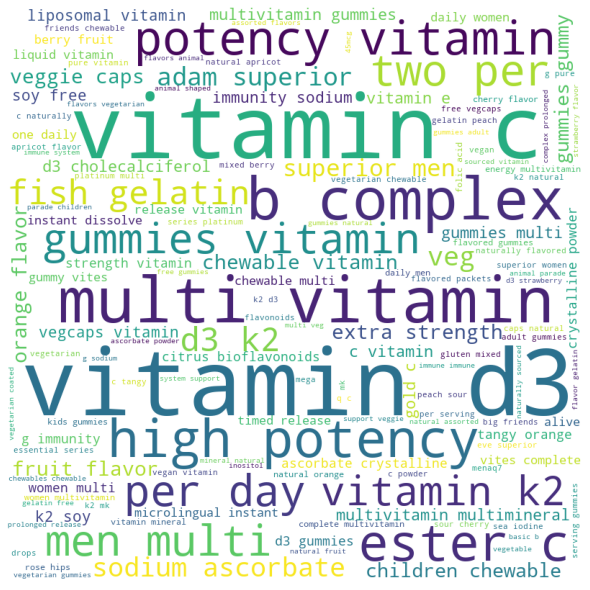

In [16]:
comment_words = '' 
stopwords = list(STOPWORDS)

# Add more stop words because these words don't contribute meaniningful insights:
z=['mcg','ml','iu','fl','oz','mg','softgels','capsules','tablets','plus','d']
for i in z:
    stopwords.append(i)
# iterate through the csv file 
for val in df['item_name']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()


#### - It seems like Vitamin D3, K2, C are the most popular vitamins and then Multivitamin, B complex 
#### - Users tend to buy products which are advertised as high potency
#### - Gummies and chewable form seems to be one of the popular vitamin forms.

In [17]:
# Create function to get positive reviews:

def get_positive(x):
    individual_rate = x["individual_rating"]
    if individual_rate >= 4:  # reviews with rating from 4-5 are considered positive reviews
        return x["review_contents"]
    return "Not positive"

# Create function to get negative reviews:

def get_negative(x):
    individual_rate = x["individual_rating"]
    if individual_rate < 4:  # reviews with rating lower than 4 are considered negative reviews
        return x["review_contents"]
    return "Not positive"

pos_review = df[["individual_rating", "review_contents"]].apply(get_positive, axis = 1)
neg_review = df[["individual_rating", "review_contents"]].apply(get_negative, axis = 1)


#### Visualize the popular themes in terms of positive review contents:

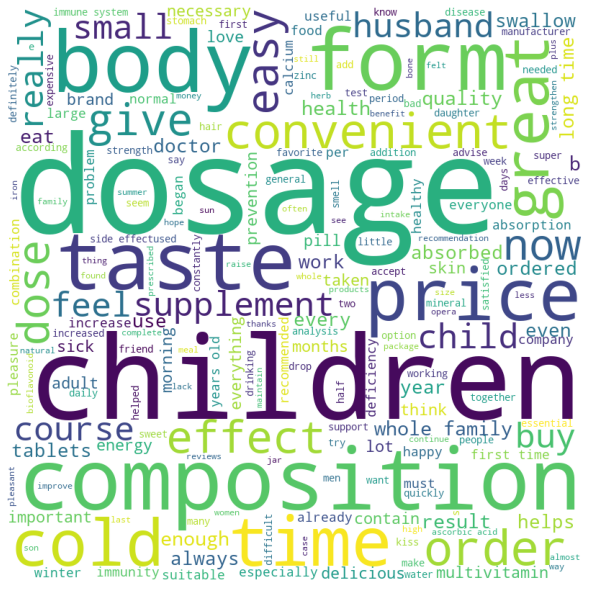

In [23]:
comment_words = '' 
stopwords = list(STOPWORDS) 

# Add more stop words because these words don't contribute meaniningful insights:
y=['negative','complex','capsules','well','drug','tablet','help','day','month','recommend','excellent','took','review','positive','good','vitamin',
   'vitamins','good','will','take','product','capsule','bought','one','better','drink','yes',
   'drank','c','d','d3','much','taking','liked','thank','level','k2','may','need','never','best','without']
for i in y:
    stopwords.append(i)

# iterate through the pos_review
for val in pos_review: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()



#### - People tend to buy the products with good dosage, taste, price, form, and composition.
#### - People like the convenience, effect time of the product.

#### Visualize the popular themes in terms of negative review content:

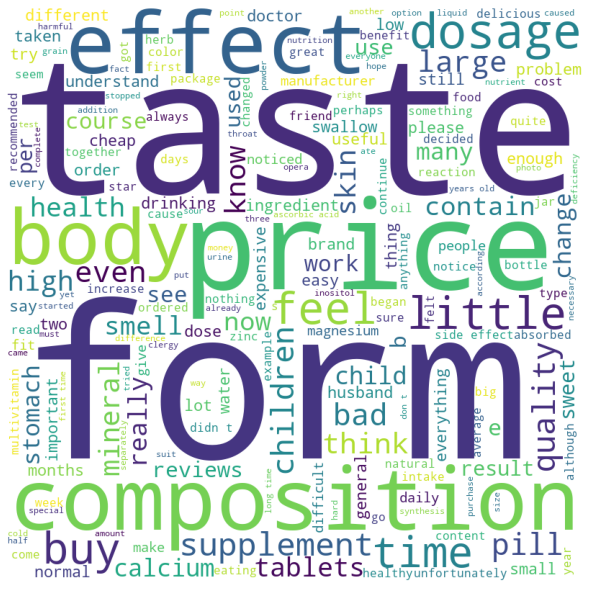

In [24]:
comment_words = '' 
stopwords = list(STOPWORDS) 

# Add more stop words because these words don't contribute meaniningful insights:
y=['negative','complex','capsules','well','drug','tablet','help','day','month','recommend','excellent','took','review','positive','good','vitamin',
   'vitamins','good','will','take','product','capsule','bought','eat','one','better','drink','yes',
   'drank','c','d','d3','much','taking','liked','thank','level','k2','may','need','never','best','without']
for i in y:
    stopwords.append(i)

# iterate through the neg_review
for val in neg_review: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()


#### - The themes of negative reviews are pretty similar with the positive review which focus on the form, taste, price, composition, and effect.

END.